100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:05<00:00, 8.50MB/s]


Weights loaded successfully.


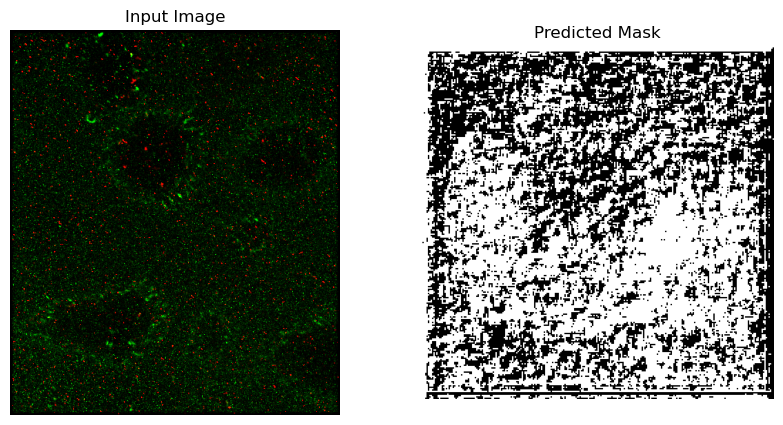

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import os

# Function to download file
def download_weights(url, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    file_name = os.path.join(destination_folder, url.split('/')[-1])
    torch.hub.download_url_to_file(url, file_name)
    return file_name

# Download pre-trained weights for ResNet18
resnet_url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
weights_folder = './models/Resnet18'
weights_file_resnet = download_weights(resnet_url, weights_folder)

# Load the pre-trained model
model = smp.Unet('resnet18', in_channels=3, classes=1)  # Assuming binary segmentation

# Load the pre-trained weights for ResNet18
try:
    checkpoint_resnet = torch.load(weights_file_resnet)
    model.encoder.load_state_dict(checkpoint_resnet)
    print("Weights loaded successfully.")
except Exception as e:
    print("Error loading weights:", e)

# Set the model to evaluation mode
model.eval()

# Define a function to apply the model to an input image
def predict_image(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Forward pass
    with torch.no_grad():
        output = model(input_batch)

    # Post-process the output to get the segmentation mask
    sigmoid = torch.nn.Sigmoid()
    pred_probs = sigmoid(output.squeeze(0)).cpu().numpy()  # Convert to numpy array
    mask = (pred_probs > 0.5).astype(np.uint8)  # Binarize probabilities

    return mask

# Example usage
image_path = 'Sugars_Kasumi1_NPL_GSL-1_posXY1_channels_t0_posZ0_thumbnail.png'
mask = predict_image(image_path, model)

# Visualize the input image and the predicted mask
image = Image.open(image_path)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()


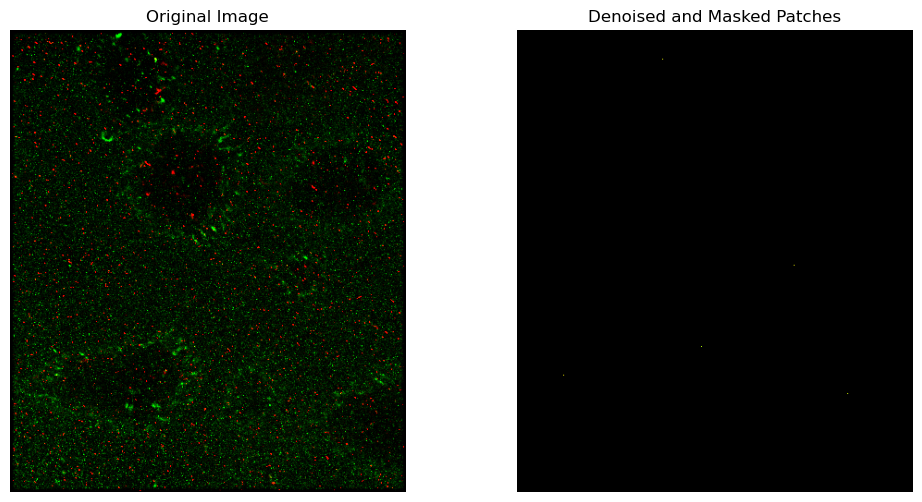

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'Sugars_Kasumi1_NPL_GSL-1_posXY1_channels_t0_posZ0_thumbnail.png'
image = cv2.imread(image_path)

# Denoise the image using bilateral filtering
denoised_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

# Preprocess the denoised image (convert to grayscale)
gray = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary mask
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank mask to draw the contours
mask = np.zeros_like(gray)

# Draw contours on the mask
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

# Apply the mask to the original image
result = cv2.bitwise_and(image, image, mask=mask)

# Display the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Denoised and Masked Patches')
plt.axis('off')

plt.show()


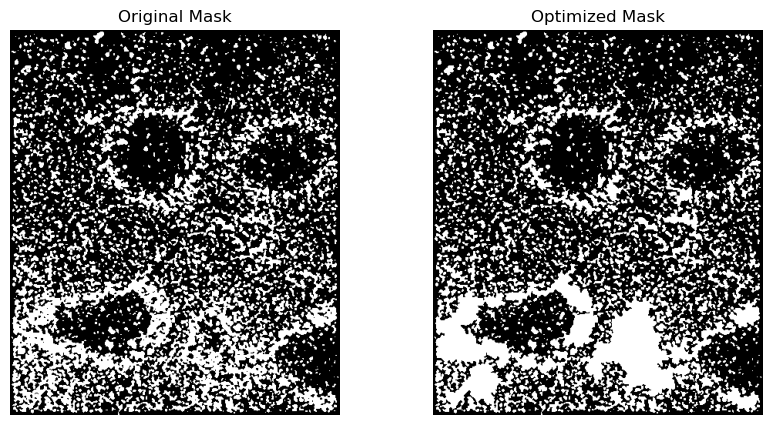

In [98]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_mask(image,threshold):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
     # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    # Apply thresholding
    _, mask = cv2.threshold(blurred_image, threshold, 255, cv2.THRESH_BINARY)

    return mask

def optimize_mask(image, mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a black mask to draw the optimized contours
    optimized_mask = np.zeros_like(mask)
    
    # Draw the optimized contours on the mask
    cv2.drawContours(optimized_mask, contours, -1, (255), thickness=cv2.FILLED)
    
    return optimized_mask

# Load the image
image = cv2.imread('./Sugars_Kasumi1_NPL_GSL-1_posXY1_channels_t0_posZ0_thumbnail.png')

treshold=15
# Create a mask for the image
mask = create_mask(image,treshold)

# Optimize the mask
optimized_mask = optimize_mask(image, mask)

# Display the images using Matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(optimized_mask, cmap='gray')
plt.title('Optimized Mask')
plt.axis('off')

plt.show()


<class 'numpy.ndarray'>


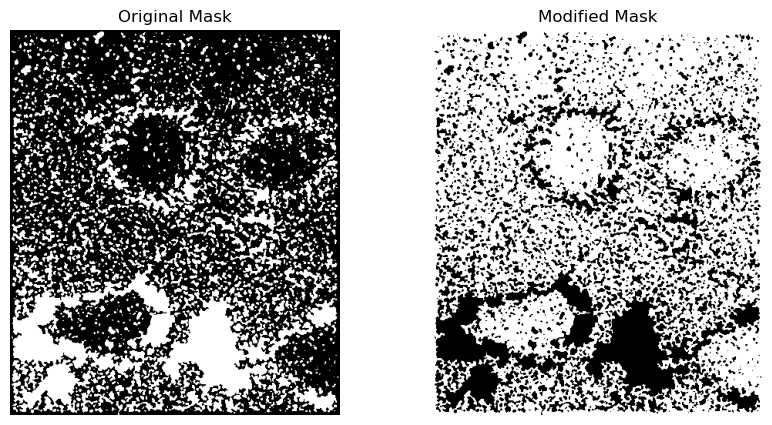

In [40]:
def invert_mask(mask):
    return 255 - mask

# Assuming mask is already computed as a numpy array

print(type(mask))
# Invert the mask
inverted_mask = invert_mask(optimized_mask)

# Display the original mask and the modified mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(optimized_mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')

axes[1].imshow(inverted_mask, cmap='gray')
axes[1].set_title('Modified Mask')
axes[1].axis('off')

plt.show()


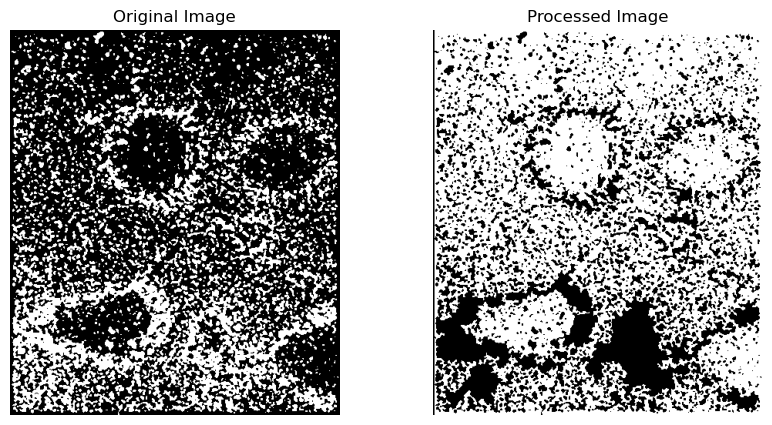

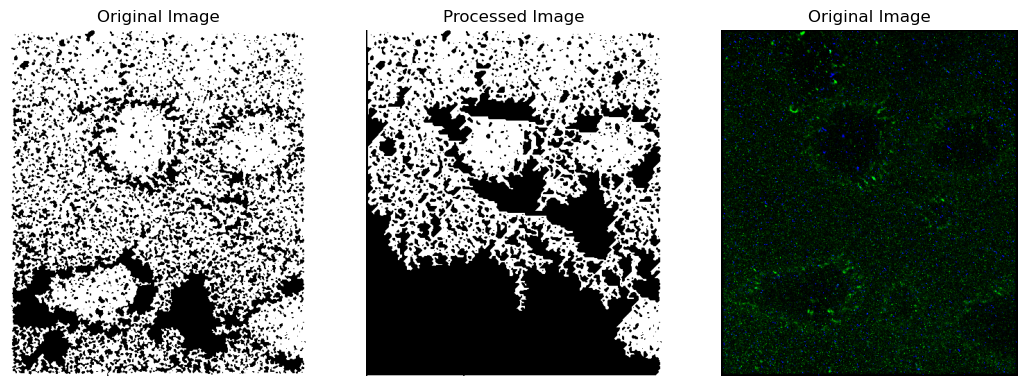

In [73]:
import cv2
import numpy as np

def process_image(img):
    # Convert image to binary
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Invert the binary image
    inverted_img = cv2.bitwise_not(binary_img)

    # Perform morphological operations to detect white pixels surrounded by black
    kernel = np.ones((4, 2), np.uint8)
    dilated_img = cv2.dilate(inverted_img, kernel, iterations=100)

    # Bitwise AND operation to detect the desired pixels
    result_img = cv2.bitwise_and(binary_img, dilated_img)

    return result_img


# Process the image
output_image = process_image(inverted_mask)

# Plot the images using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')

plt.show()

def majority_black_neighborhood(img, threshold=0.5):
    """
    Converts white pixels surrounded by a majority of black pixels to black.
    
    Args:
    - img: Input grayscale image.
    - threshold: Threshold for the majority of black pixels in the neighborhood.
    
    Returns:
    - Modified image.
    """
    # Define a kernel for neighborhood analysis
    kernel = np.ones((3, 3), np.uint8)
    
    # Iterate over each pixel in the image
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            # Get the pixel value
            pixel_value = img[i, j]
            
            # If the pixel is white
            if pixel_value == 255:
                # Extract the neighborhood
                neighborhood = img[i-1:i+2, j-1:j+2]
                
                # Count the number of black pixels in the neighborhood
                black_pixels = np.sum(neighborhood == 0)
                
                # If the majority of the neighborhood is black
                if black_pixels >= threshold * 8:
                    # Set the pixel to black
                    img[i, j] = 0
    
    return img


# Apply the majority black neighborhood operation
modified_image = majority_black_neighborhood(output_image)

# Plot the images using matplotlib
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.imshow(inverted_mask, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(modified_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.show()

(21, 500, 428)


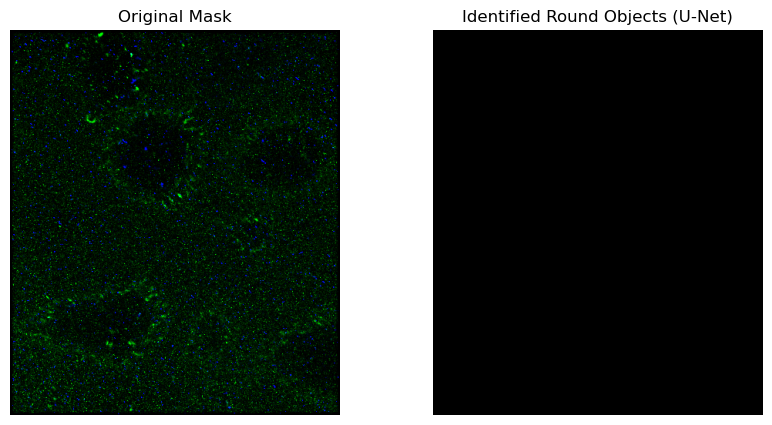

(21, 500, 428)


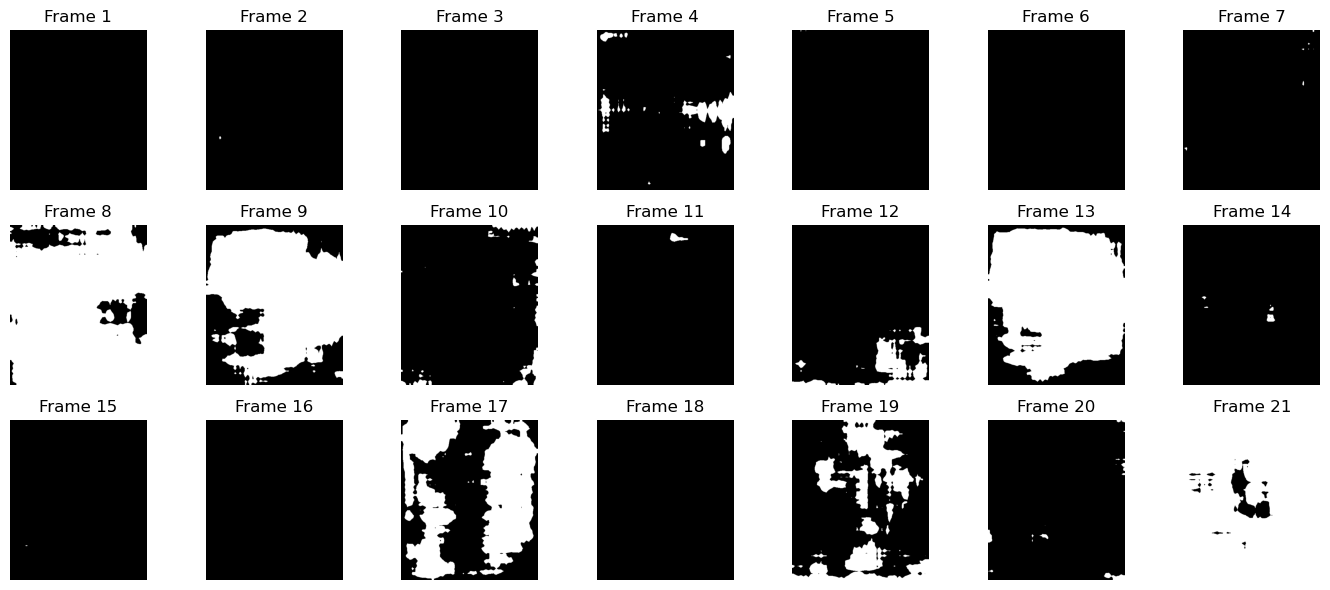

In [102]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
 
# Importing Necessary Libraries
from skimage import data
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Load a pre-trained U-Net model
        self.model = models.segmentation.fcn_resnet50(pretrained=True)

    def forward(self, x):
        return self.model(x)['out']

# Define a function to preprocess the image
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img

# Define a function to postprocess the mask
def postprocess_mask(mask):
    mask[mask >= 0.5] = 255
    mask[mask < 0.5] = 0
    return mask.squeeze().numpy().astype(np.uint8)

# Load the pre-trained U-Net model
model = UNet()

# Set the model to evaluation mode
model.eval()

#image = data.astronaut()
# Load and preprocess the example mask (replace 'example_mask.png' with your mask path)
img_tensor = preprocess_image(image)

# Get the predicted mask from the model
with torch.no_grad():
    mask_pred = model(img_tensor)
    
# Postprocess the predicted mask
mask_pred = postprocess_mask(mask_pred)
print(mask_pred.shape)
# Display the original mask and the identified round objects
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.array(image), cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')

axes[1].imshow(mask_pred[0], cmap='gray')
axes[1].set_title('Identified Round Objects (U-Net)')
axes[1].axis('off')

plt.show()


print(mask_pred.shape)
# Plot all 21 frames
fig, axes = plt.subplots(3, 7, figsize=(14, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(mask_pred[i], cmap='gray')  # Assuming grayscale images
    ax.axis('off')
    ax.set_title(f'Frame {i+1}')

plt.tight_layout()
plt.show()
